In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
import h5py # reccommended by the interpreter (weird) for loading older `.mat` files
import time

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the gop benchmark
# device = torch.device('cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


# Importing the Dataset

In [90]:
class NYUDepthDataset (Dataset):
	def __init__(self, file_path, transform=None, target_transform=None):
		self.file_path = file_path
		self.data = h5py.File(file_path, 'r')
		self.transform = transform
		self.target_transform = target_transform

	def __len__(self):
		return len(self.data['images'])
	
	def __getitem__(self, idx):
		rgb_image = np.swapaxes(self.data['images'][idx], 0, 2)
		depth_image = np.swapaxes(self.data['depths'][idx], 0, 1)

		# print(rgb_image.shape)

		if self.transform:
			# print(torch.from_numpy(rgb_image).size())
			rgb_image = self.transform(rgb_image)
		if self.target_transform:
			depth_image = self.target_transform(depth_image)
			depth_image -= depth_image.min()
			depth_image /= depth_image.max()

		return rgb_image, depth_image

In [91]:
def show_grid(size, images, text=None):
	figure, axs = plt.subplots(nrows=size[0], ncols=size[1])
	figure.tight_layout()

	for i in range(len(axs)):
		for j in range(len(axs[i])):
			axs[i][j].imshow(images[i*len(axs[i]) + j])
			axs[i][j].set_xticks([])
			axs[i][j].set_yticks([])
			if text:
				axs[i][j].set_title(text[i*len(axs[i]) + j])


Image Data: 1449 images of size torch.Size([3, 480, 640])
tensor([[[0.5247, 0.5247, 0.5248,  ..., 0.2445, 0.2445, 0.2445],
         [0.5247, 0.5247, 0.5248,  ..., 0.2445, 0.2445, 0.2445],
         [0.5246, 0.5246, 0.5247,  ..., 0.2445, 0.2444, 0.2444],
         ...,
         [0.2199, 0.2198, 0.2198,  ..., 0.1556, 0.1554, 0.1554],
         [0.2198, 0.2198, 0.2197,  ..., 0.1558, 0.1556, 0.1555],
         [0.2198, 0.2197, 0.2197,  ..., 0.1558, 0.1557, 0.1556]]])


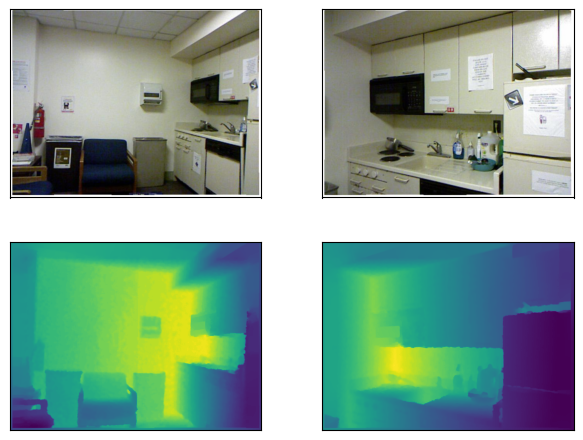

In [92]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=(0, 0, 0), std=(255, 255, 255))
])

depth_transform = transforms.Compose([
	transforms.ToTensor()
])

rng = torch.Generator().manual_seed(420)

NYU_data = NYUDepthDataset('data/NYU/nyu_depth_v2_labeled.mat', transform=transform, target_transform=depth_transform)
NYU_training, NYU_testing = random_split(NYU_data, (0.85, 0.15), generator=rng)

image_width, image_height = NYU_data[0][1].shape[1:]
num_shown = 2

def npImage(tensor):
	return np.swapaxes(np.swapaxes(tensor.detach().numpy(), 0, 2), 0, 1)

plot_images = [npImage(torch.mul(NYU_data[i][0], 255)) for i in range(num_shown)]
plot_images.extend([npImage(NYU_data[i][1]) for i in range(num_shown)])

print(f'Image Data: {len(NYU_data)} images of size {NYU_data[0][0].shape}')
print(NYU_data[0][1])
show_grid((2, num_shown), plot_images)

# Initialising the Model

In [93]:
class fDense (nn.Module):
	class compoundLayer (nn.Module):
		def __init__(self, inChannels, k):
			super().__init__()
			self.norm = nn.BatchNorm2d(inChannels)
			self.conv = nn.Conv2d(inChannels, k, 3, stride=1, padding=1, padding_mode='reflect')
		
		def forward(self, x):
			intermediateOutput = F.relu(self.norm(x))
			x = torch.cat((x, self.conv(intermediateOutput)), dim=1)
			return x


	def __init__(self, inChannels, outChannels, l=4, k=32):
		super().__init__()
		modules = nn.ModuleList()
		for i in range(l):
			# the input channel count for layer i+1 is k_{i+1} = k_0 + ik
			modules.append(fDense.compoundLayer(inChannels + k*i, k))
		
		# 1x1 convolution to remap to correct channel number
		modules.append(nn.Conv2d(inChannels + k*l, outChannels, 1).to(device))

		self.layers = nn.Sequential(*modules)

	def forward(self, x):
		return self.layers(x)

In [94]:
class SE (nn.Module):
	def __init__(self, inChannels, outChannels, w, h):
		super().__init__()
		self.scalarUpsample = nn.Upsample((w, h))
		self.globalPool = nn.AvgPool2d((w, h))
		self.fc1 = nn.Linear(1, 1)
		self.fc2 = nn.Linear(1, 1)

		self.conv = nn.Conv2d(inChannels, outChannels, 1)

	def forward(self, x):
		scalars = self.globalPool(x)
		scalars = F.relu(self.fc1(scalars))
		scalars = F.sigmoid(self.fc2(scalars))
		scalars = self.scalarUpsample(scalars)
		x = self.conv(torch.mul(x, scalars))
		return x

In [95]:
class DisparityConvolution (nn.Module):
	def __init__(self, inChannels):
		super().__init__()
		self.conv = nn.Conv2d(inChannels, 1, 3, stride=1, padding=1, padding_mode='reflect')
	
	def forward(self, x):
		# paper uses sigmoid, switching to relu for data
		x = F.sigmoid(self.conv(x))
		# x = F.relu(self.conv(x))
		return x

In [96]:
class FastMDE (nn.Module):
	inputSize = (0, 0)
	layers = []

	def __init__(self, w, h):
		super().__init__()
		self.inputSize = (w, h)

		self.pool = nn.MaxPool2d(2)
		self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

		# several layers of increasing channels and decreasing resolutions
		
		self.feature1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)
		self.feature2 = nn.Sequential(nn.Conv2d(16, 24, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)
		self.feature3 = nn.Sequential(nn.Conv2d(24, 32, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)
		self.feature4 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)
		self.feature5 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)

		self.ese4 = SE(192, 128, w//16, h//16)
		self.ese3 = SE(96, 64, w//8, h//8)
		self.ese2 = SE(56, 32, w//4, h//4)
		self.ese1 = SE(40, 24, w//2, h//2)

		self.fDense5 = nn.Sequential(fDense(128, 128), self.upsample)
		self.fDense4 = nn.Sequential(fDense(128, 128), self.upsample)
		self.fDense3 = nn.Sequential(fDense(64, 64), self.upsample)
		self.fDense2 = nn.Sequential(fDense(32, 32), self.upsample)
		self.fDense1 = nn.Sequential(fDense(72, 72), self.upsample)

		self.dse4 = nn.Sequential(nn.Conv2d(320, 320, 3, stride=1, padding=1, padding_mode='reflect'), SE(320, 128, w//16, h//16))
		self.dse3 = nn.Sequential(nn.Conv2d(224, 224, 3, stride=1, padding=1, padding_mode='reflect'), SE(224, 64, w//8, h//8))
		self.dse2 = nn.Sequential(nn.Conv2d(120, 120, 3, stride=1, padding=1, padding_mode='reflect'), SE(120, 32, w//4, h//4))
		self.dse1 = nn.Sequential(nn.Conv2d(72, 72, 3, stride=1, padding=1, padding_mode='reflect'), SE(72, 16, w, h))

		self.disparity = DisparityConvolution(16)

		print(self)

	def forward(self, x):
		layer1 = self.feature1(x)
		layer2 = self.feature2(layer1)
		layer3 = self.feature3(layer2)
		layer4 = self.feature4(layer3)
		layer5 = self.feature5(layer4)

		layer6 = self.ese4(torch.cat((self.upsample(layer5), layer4), dim=1))
		layer7 = self.ese3(torch.cat((self.upsample(layer4), layer3), dim=1))
		layer8 = self.ese2(torch.cat((self.upsample(layer3), layer2), dim=1))
		layer9 = self.ese1(torch.cat((self.upsample(layer2), layer1), dim=1))

		layer10 = self.fDense5(layer5)
		layer11 = self.dse4(torch.cat((layer10, layer6, layer4), dim=1))
		layer12 = self.fDense4(layer11)
		layer13 = self.dse3(torch.cat((layer12, layer7, layer3), dim=1))
		layer14 = self.fDense3(layer13)
		layer15 = self.dse2(torch.cat((layer14, layer8, layer2), dim=1))
		layer16 = self.fDense2(layer15)
		layer17 = self.fDense1(torch.cat((layer16, layer9, layer1), dim=1))
		layer18 = self.dse1(layer17)

		x = self.disparity(layer18)

		return x

In [97]:
model = FastMDE(image_width, image_height).to(device)

FastMDE(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
  (feature1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fea

In [98]:
def getNumParams(model):
	pp=0
	for p in list(model.parameters()):
		nn=1
		for s in list(p.size()):
			nn = nn*s
		pp += nn
	return pp

print(getNumParams(model))

2616473


[[[0.513526   0.5131754  0.5132128  ... 0.51196444 0.5120379  0.5122005 ]
  [0.5127432  0.5124091  0.5122522  ... 0.51243323 0.5123792  0.51237625]
  [0.5130088  0.5125189  0.5121555  ... 0.5117428  0.51182574 0.51181793]
  ...
  [0.5298499  0.5299584  0.530326   ... 0.5125334  0.5119584  0.5126423 ]
  [0.5292076  0.5296512  0.5295384  ... 0.51243955 0.51172215 0.51235235]
  [0.5296704  0.5298833  0.52983934 ... 0.51288325 0.5120204  0.5125084 ]]]


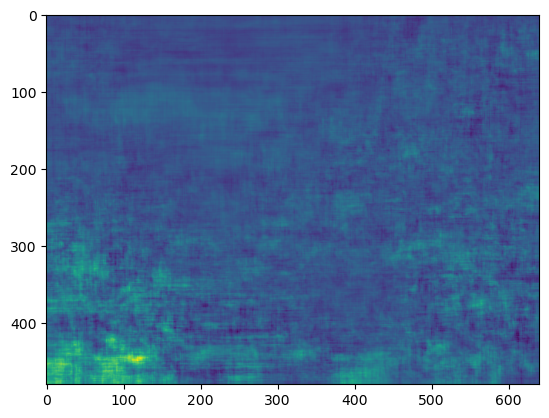

In [99]:
output = model.forward(default_collate([NYU_data[i][0].to(device) for i in range(2)]))

plt.imshow(npImage(output[0].cpu()))
print(output.cpu().detach().numpy()[0])

In [100]:
L1Loss = nn.L1Loss()

# add a loss fn that takes into account each scale of output, maybe? compares with pooled ground truth?

# but for now
criterion = nn.MSELoss()
# criterion = L1Loss

# and try Adam optimizer
# optimizer = SGD(model.parameters(), lr=0.00005, momentum=0.9)
optimizer = Adam(model.parameters(), lr=5e-5)

In [101]:
NYU_trainingDataLoader = DataLoader(NYU_training, batch_size=8, shuffle=True, num_workers=0)
NYU_testingDataLoader = DataLoader(NYU_training, batch_size=8, shuffle=True, num_workers=0)

def train_one_epoch(model, epoch_index):
	running_loss = 0.
	last_loss = 0.

	# Here, we use enumerate(training_loader) instead of
	# iter(training_loader) so that we can track the batch
	# index and do some intra-epoch reporting
	for i, data in enumerate(NYU_trainingDataLoader):
		# Every data instance is an input + label pair
		inputs, labels = data
		inputs = inputs.to(device)
		labels = labels.to(device)

		# Zero your gradients for every batch!
		optimizer.zero_grad()

		# Make predictions for this batch
		outputs = model(inputs)

		# Compute the loss and its gradients
		loss = criterion(outputs, labels)
		loss.backward()

		# Adjust learning weights
		optimizer.step()

		# Gather data and report
		running_loss += loss.item()

	return running_loss / len(NYU_trainingDataLoader)

In [102]:
EPOCHS = 20

losses, v_losses = [], []

for epoch in range(EPOCHS):
	print(f'-=-=-=-=- EPOCH {epoch + 1} -=-=-=-=-')

	# Make sure gradient tracking is on, and do a pass over the data
	model.train(True)
	avg_loss = train_one_epoch(model, epoch)
	losses.append(avg_loss)


	running_vloss = 0.0
	# Set the model to evaluation mode, disabling dropout and using population
	# statistics for batch normalization.
	model.eval()

	# Disable gradient computation and reduce memory consumption.
	with torch.no_grad():
		for i, vdata in enumerate(NYU_testingDataLoader):
			vinputs, vlabels = vdata

			vinputs = vinputs.to(device)
			vlabels = vlabels.to(device)

			voutputs = model(vinputs)
			vloss = criterion(voutputs, vlabels)
			running_vloss += vloss

	avg_vloss = running_vloss / (i + 1)
	v_losses.append(avg_vloss)

	print(f'Training loss (MSE): {avg_loss}')
	print(f'Testing loss (MSE): {avg_vloss}')

	torch.save(model.state_dict(), f'states/epoch_{epoch + 1}.pt')

-=-=-=-=- EPOCH 1 -=-=-=-=-


KeyboardInterrupt: 

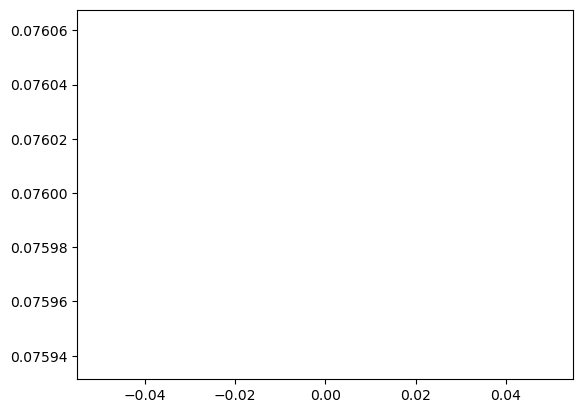

In [ ]:
v_losses = [l.cpu() for l in v_losses]

currentTime = time.localtime()

with open(f'output/losses_{currentTime.tm_year}-{currentTime.tm_mon}-{currentTime.tm_mday}_{currentTime.tm_hour}:{currentTime.tm_min}:{currentTime.tm_sec}.csv', 'w') as f:
	fileBody = 'loss,val loss'
	for i in range(len(losses)):
		fileBody += f'{losses[i]},{v_losses[i]}'
	f.write(fileBody)


plt.plot(range(len(losses)), losses)
plt.plot(range(len(v_losses)), v_losses)

[[[0.48877594 0.48857865 0.48559135 ... 0.48711205 0.48663622 0.489577  ]
  [0.48525718 0.4797383  0.4737713  ... 0.47784504 0.4801024  0.4822181 ]
  [0.484637   0.48049465 0.47551724 ... 0.48023695 0.48476556 0.4844012 ]
  ...
  [0.4881192  0.48155007 0.47748938 ... 0.47871462 0.48274392 0.48073477]
  [0.48737144 0.48098174 0.47718847 ... 0.4814167  0.48558    0.48360264]
  [0.49116552 0.48520374 0.48433205 ... 0.48537987 0.48876882 0.48590875]]]


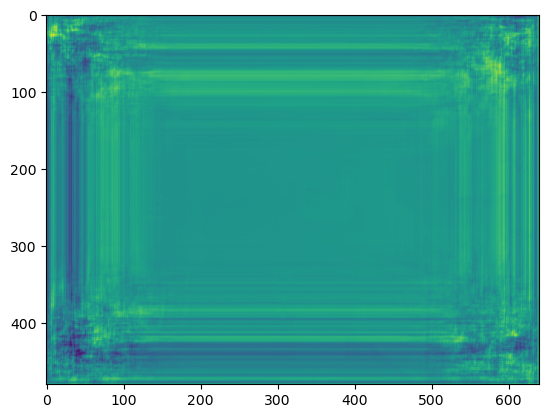

In [ ]:
output = model.forward(default_collate([NYU_data[i][0].to(device) for i in range(2)]))

plt.imshow(npImage(output[0].cpu()))
print(output.cpu().detach().numpy()[0])

Image Data: 1449 images of size torch.Size([3, 480, 640])


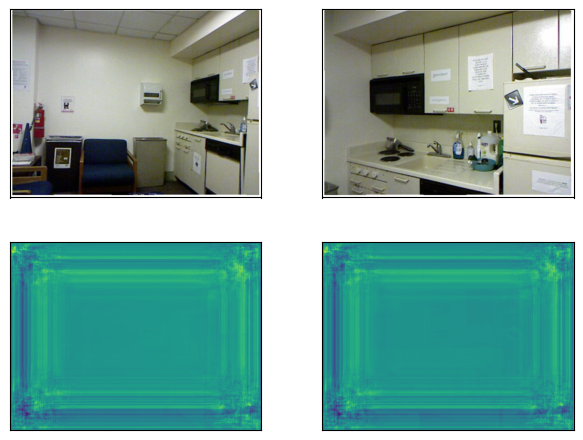

In [ ]:
plot_images = [npImage(torch.mul(NYU_data[i][0], 255)) for i in range(num_shown)]
plot_images.extend([npImage(img.cpu()) for img in output])

print(f'Image Data: {len(NYU_data)} images of size {NYU_data[0][0].shape}')

show_grid((2, num_shown), plot_images)